<a href="https://colab.research.google.com/github/javadan/CGIAR-Crop-Damage-Classification-Challenge/blob/main/CNN_and_histogram_CGIAR_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

efficientvit

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.6 MB/s eta 0:00:00
Copying and unzipping files to local directory...


epoch,train_loss,valid_loss,cross_entropy,time
0,0.024504,0.026695,0.330448,12:47
1,0.023089,0.022465,0.310865,12:36
2,0.022388,0.021724,0.316442,12:45
3,0.021845,0.021964,0.298720,12:40
4,0.021000,0.020682,0.290407,12:49
5,0.020548,0.020257,0.296677,12:50
6,0.020315,0.019479,0.289959,12:44
7,0.020300,0.020504,0.288652,12:42
8,0.019810,0.019014,0.289403,12:41
9,0.019559,0.018201,0.276819,12:43


Better model found at epoch 0 with valid_loss value: 0.02669532410800457.
Better model found at epoch 1 with valid_loss value: 0.022464541718363762.
Better model found at epoch 2 with valid_loss value: 0.021724196150898933.
Better model found at epoch 4 with valid_loss value: 0.02068180777132511.
Better model found at epoch 5 with valid_loss value: 0.020256953313946724.
Better model found at epoch 6 with valid_loss value: 0.01947862096130848.
Better model found at epoch 8 with valid_loss value: 0.01901383511722088.
Better model found at epoch 9 with valid_loss value: 0.018201472237706184.
Better model found at epoch 11 with valid_loss value: 0.017726527526974678.
Better model found at epoch 12 with valid_loss value: 0.017493855208158493.
Better model found at epoch 13 with valid_loss value: 0.017468824982643127.
No improvement since epoch 11: early stopping


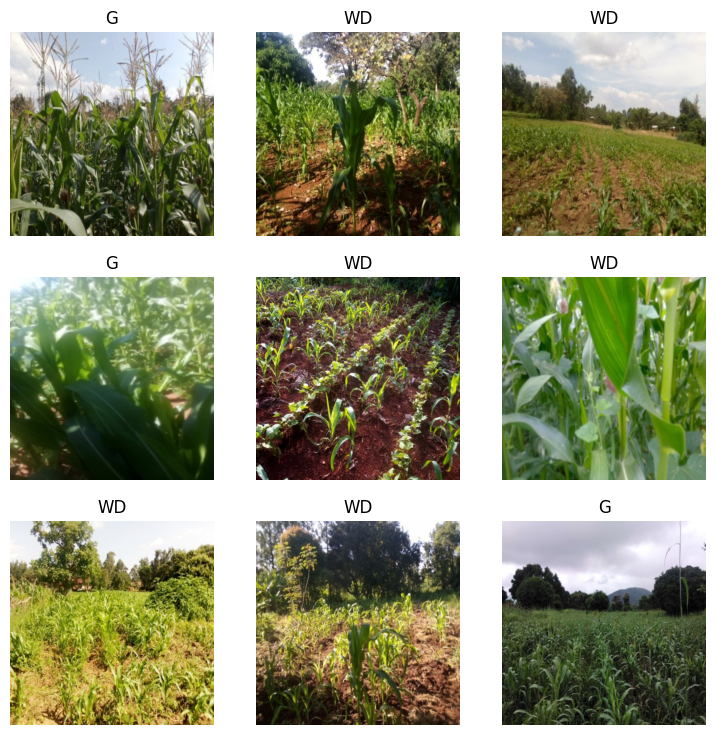

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install timm



import os

from fastcore.parallel import *
from pathlib import Path
from fastai.vision.all import *
from timm import create_model
import pandas as pd
import os
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from fastai.callback.all import CutMix
from fastai.test_utils import *
from datetime import datetime
from fastai.losses import FocalLossFlat
from fastai.vision.augment import RandomResizedCrop



# Target directory where images will be copied
local_image_dir = '/content/images'

# Check if the directory exists and has files
if not os.path.exists(local_image_dir) or not os.listdir(local_image_dir):
    print("Copying and unzipping files to local directory...")

    # Create the target directory if it doesn't exist
    if not os.path.exists(local_image_dir):
        os.makedirs(local_image_dir)

    # Copy the zip file
    !cp /content/drive/MyDrive/cgiar/images/images.zip /content/

    # Unzip the file into the target directory
    !unzip -q /content/images.zip -d /content/images
else:
    print("Files already copied to local directory.")


####################################
SEED = 1032
#N_FOLDS = 1
BATCH_SIZE = 45
IMGSZ = 384 #224 #384
EPOCHS = 15 #10 #5 #3
INIT_LR = 3e-4 #2e-4
NUM_WORKER = 8
PATIENCE = 3

MODEL_BASE = 'efficientvit_l2.r384_in1k' # 'tiny_vit_21m_224.dist_in22k' # 'caformer_s36.sail_in22k' #'convnext_base.fb_in22k'

#'maxxvitv2_rmlp_base_rw_384.sw_in12k_ft_in1k'  same score as efficientvit_l2 more or less
####################################

MODELS_DIR = '/content/drive/MyDrive/models/'
DATASET_DIR = '/content/drive/MyDrive/cgiar/'


current_datetime = datetime.now().strftime("%Y%m%d-%H%M%S")

MODELS_PATH = os.path.join(MODELS_DIR, f"{MODEL_BASE}_{current_datetime}")

os.makedirs(MODELS_PATH, exist_ok=True)

set_seed(SEED, reproducible=True)

class CustomFocalLoss(nn.Module):
    def __init__(self, gamma=2., alpha=.25, reduction='mean'):
        super(CustomFocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction == 'sum':
            return F_loss.sum()
        elif self.reduction == 'none':
            return F_loss
        return F_loss.mean()



def prepare_train_data(data, image_dir):
    df = data.copy()
    df['image_id'] = df['filename'].apply(lambda x: x.split('.')[0])
    df = df.drop_duplicates(subset='image_id', keep='first')

    df['target'] = df['damage']
    df['path'] = df['filename'].apply(lambda x: f'{image_dir}/{x}')

    return df


def cross_entropy(predictions, targets):
        predictions = predictions.sigmoid()
        return torch.where(targets==1, 1-predictions, predictions).mean()

def train_and_evaluate_model(model_base, train_data):
    df = train_data.copy()

    dls = ImageDataLoaders.from_df(
        df, # pass in train DataFrame
        valid_pct=0.2,  # Assuming 20% for validation; adjust as needed
        seed=SEED, # seed for reproducibility
        fn_col='path', # filename/path is in the second column of the DataFrame
        label_col='target', # label is in the first column of the DataFrame
        label_delim=' ',
        y_block=MultiCategoryBlock, # The type of target
        bs=BATCH_SIZE, # pass in batch size
        num_workers=NUM_WORKER,
        item_tfms=RandomResizedCrop(size=IMGSZ, min_scale=0.75),
        batch_tfms=setup_aug_tfms([Resize(IMGSZ), Brightness(), Contrast()]))

    dls.show_batch()


    # Model setup
    model = create_model(model_base, pretrained=False, num_classes=dls.c)

    learn = Learner(dls, model, loss_func=CustomFocalLoss(), metrics=AccumMetric(cross_entropy)).to_fp16()

    # learn = Learner(dls, model, loss_func=BCEWithLogitsLossFlat(), metrics=AccumMetric(cross_entropy)).to_fp16()

    # Add the CutMix callback
    cutmix = CutMix(1.)  # The parameter is alpha, you can adjust it as needed

    # Training the model
    learn.fit_one_cycle(EPOCHS, INIT_LR, cbs=[SaveModelCallback(), EarlyStoppingCallback(monitor='cross_entropy', comp=np.less, patience=PATIENCE), CSVLogger(fname=f'{MODELS_PATH}/{model_base}_history.csv', append=True), cutmix])

    learn = learn.to_fp32()
    # Saving the trained model
    learn.save(f'{MODELS_PATH}/{model_base}', with_opt=True)



train = pd.read_csv(f'{DATASET_DIR}Train.csv')
os.chdir('/content')

train_data = prepare_train_data(train,  'images/images/')


train_and_evaluate_model(MODEL_BASE, train_data)

####################################
SAVE_NAME = MODEL_BASE
####################################

# Creating a submission directory
os.makedirs(f'{MODELS_PATH}/submission', exist_ok=True)

# Reading the test dataset
test_df = pd.read_csv(f'{DATASET_DIR}/Test.csv')
test_df['path'] = test_df['filename'].map(lambda x: f'images/images/{x}')

# Load the trained model
dls = ImageDataLoaders.from_df(
    train_data, # pass in train DataFrame
    valid_pct=0.2, # 80-20 train-validation random split
    seed=SEED, # seed
    fn_col='path', # filename/path is in the second column of the DataFrame
    label_col='target', # label is in the first column of the DataFrame
    label_delim=' ',
    y_block=MultiCategoryBlock, # The type of target
    bs=BATCH_SIZE, # pass in batch size
    num_workers=NUM_WORKER,
    item_tfms=Resize(IMGSZ), # pass in item_tfms
    batch_tfms=setup_aug_tfms([Brightness(), Contrast()]))

model = create_model(f'{MODEL_BASE}', pretrained=False, num_classes=dls.c)
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=AccumMetric(cross_entropy)).to_fp16()

# Load your trained model
learn.load(f'{MODELS_PATH}/{MODEL_BASE}')

# Prepare the data for testing
test_dl = dls.test_dl(test_df)
preds, _ = learn.get_preds(dl=test_dl)

# Join the predictions with the test dataframe
test_df = test_df.join(pd.DataFrame(preds.numpy(), columns=dls.vocab))

# Preparing the submission file
sample_submission_df = pd.read_csv(f"{DATASET_DIR}/SampleSubmission.csv")
sample_submission_df = sample_submission_df[['ID']]
sample_submission_df = pd.merge(sample_submission_df, test_df[['ID'] + list(dls.vocab)], on='ID')
sample_submission_df.to_csv(f"{MODELS_PATH}/submission/{SAVE_NAME}_notta.csv", index=False)





caformer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install timm



import os

from fastcore.parallel import *
from pathlib import Path
from fastai.vision.all import *
from timm import create_model
import pandas as pd
import os
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from fastai.callback.all import CutMix
from fastai.test_utils import *
from datetime import datetime
from fastai.losses import FocalLossFlat
from fastai.vision.augment import RandomResizedCrop



# Target directory where images will be copied
local_image_dir = '/content/images'

# Check if the directory exists and has files
if not os.path.exists(local_image_dir) or not os.listdir(local_image_dir):
    print("Copying and unzipping files to local directory...")

    # Create the target directory if it doesn't exist
    if not os.path.exists(local_image_dir):
        os.makedirs(local_image_dir)

    # Copy the zip file
    !cp /content/drive/MyDrive/cgiar/images/images.zip /content/

    # Unzip the file into the target directory
    !unzip -q /content/images.zip -d /content/images
else:
    print("Files already copied to local directory.")


####################################
SEED = 1032
#N_FOLDS = 1
BATCH_SIZE = 45
IMGSZ = 224 #384
EPOCHS = 15 #10 #5 #3
INIT_LR = 2e-4
NUM_WORKER = 8
PATIENCE = 3

MODEL_BASE = 'caformer_s36.sail_in22k' #'convnext_base.fb_in22k'

#'maxxvitv2_rmlp_base_rw_384.sw_in12k_ft_in1k'  same score as efficientvit_l2 more or less
####################################

MODELS_DIR = '/content/drive/MyDrive/models/'
DATASET_DIR = '/content/drive/MyDrive/cgiar/'


current_datetime = datetime.now().strftime("%Y%m%d-%H%M%S")

MODELS_PATH = os.path.join(MODELS_DIR, f"{MODEL_BASE}_{current_datetime}")

os.makedirs(MODELS_PATH, exist_ok=True)



def prepare_train_data(data, image_dir):
    df = data.copy()
    df['image_id'] = df['filename'].apply(lambda x: x.split('.')[0])
    df = df.drop_duplicates(subset='image_id', keep='first')

    df['target'] = df['damage']
    df['path'] = df['filename'].apply(lambda x: f'{image_dir}/{x}')

    return df

def cross_entropy(predictions, targets):
        predictions = predictions.sigmoid()
        return torch.where(targets==1, 1-predictions, predictions).mean()

def train_and_evaluate_model(model_base, train_data):
    df = train_data.copy()

    dls = ImageDataLoaders.from_df(
        df, # pass in train DataFrame
        valid_pct=0.2,  # Assuming 20% for validation; adjust as needed
        seed=SEED, # seed for reproducibility
        fn_col='path', # filename/path is in the second column of the DataFrame
        label_col='target', # label is in the first column of the DataFrame
        label_delim=' ',
        y_block=MultiCategoryBlock, # The type of target
        bs=BATCH_SIZE, # pass in batch size
        num_workers=NUM_WORKER,
        item_tfms=Resize(224),  # Resize images to 224x224 pixels
        batch_tfms=None  )

    dls.show_batch()


    # Model setup
    model = create_model(model_base, pretrained=True, num_classes=dls.c)

    learn = Learner(dls, model, loss_func=BCEWithLogitsLossFlat(), metrics=AccumMetric(cross_entropy)).to_fp16()

    # learn = Learner(dls, model, loss_func=BCEWithLogitsLossFlat(), metrics=AccumMetric(cross_entropy)).to_fp16()

    # Add the CutMix callback
    cutmix = CutMix(1.)  # The parameter is alpha, you can adjust it as needed

    # Training the model
    learn.fit_one_cycle(EPOCHS, INIT_LR, cbs=[SaveModelCallback(), EarlyStoppingCallback(monitor='cross_entropy', comp=np.less, patience=PATIENCE), CSVLogger(fname=f'{MODELS_PATH}/{model_base}_history.csv', append=True), cutmix])

    learn = learn.to_fp32()
    # Saving the trained model
    learn.save(f'{MODELS_PATH}/{model_base}', with_opt=True)



train = pd.read_csv(f'{DATASET_DIR}Train.csv')
os.chdir('/content')

train_data = prepare_train_data(train,  'images/images/')


train_and_evaluate_model(MODEL_BASE, train_data)

####################################
SAVE_NAME = MODEL_BASE
####################################

# Creating a submission directory
os.makedirs(f'{MODELS_PATH}/submission', exist_ok=True)

# Reading the test dataset
test_df = pd.read_csv(f'{DATASET_DIR}/Test.csv')
test_df['path'] = test_df['filename'].map(lambda x: f'images/images/{x}')

# Load the trained model
dls = ImageDataLoaders.from_df(
    train_data, # pass in train DataFrame
    valid_pct=0.2, # 80-20 train-validation random split
    seed=SEED, # seed
    fn_col='path', # filename/path is in the second column of the DataFrame
    label_col='target', # label is in the first column of the DataFrame
    label_delim=' ',
    y_block=MultiCategoryBlock, # The type of target
    bs=BATCH_SIZE, # pass in batch size
    num_workers=NUM_WORKER,
    item_tfms=Resize(IMGSZ), # pass in item_tfms
    batch_tfms=setup_aug_tfms([Brightness(), Contrast()]))

model = create_model(f'{MODEL_BASE}', pretrained=False, num_classes=dls.c)
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=AccumMetric(cross_entropy)).to_fp16()

# Load your trained model
learn.load(f'{MODELS_PATH}/{MODEL_BASE}')

# Prepare the data for testing
test_dl = dls.test_dl(test_df)
preds, _ = learn.get_preds(dl=test_dl)

# Join the predictions with the test dataframe
test_df = test_df.join(pd.DataFrame(preds.numpy(), columns=dls.vocab))

# Preparing the submission file
sample_submission_df = pd.read_csv(f"{DATASET_DIR}/SampleSubmission.csv")
sample_submission_df = sample_submission_df[['ID']]
sample_submission_df = pd.merge(sample_submission_df, test_df[['ID'] + list(dls.vocab)], on='ID')
sample_submission_df.to_csv(f"{MODELS_PATH}/submission/{SAVE_NAME}_notta.csv", index=False)





KeyboardInterrupt: 

3rd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install timm



import os

from fastcore.parallel import *
from pathlib import Path
from fastai.vision.all import *
from timm import create_model
import pandas as pd
import os
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from fastai.callback.all import CutMix
from fastai.test_utils import *
from datetime import datetime
from fastai.losses import FocalLossFlat
from fastai.vision.augment import RandomResizedCrop



# Target directory where images will be copied
local_image_dir = '/content/images'

# Check if the directory exists and has files
if not os.path.exists(local_image_dir) or not os.listdir(local_image_dir):
    print("Copying and unzipping files to local directory...")

    # Create the target directory if it doesn't exist
    if not os.path.exists(local_image_dir):
        os.makedirs(local_image_dir)

    # Copy the zip file
    !cp /content/drive/MyDrive/cgiar/images/images.zip /content/

    # Unzip the file into the target directory
    !unzip -q /content/images.zip -d /content/images
else:
    print("Files already copied to local directory.")


####################################
SEED = 1032
#N_FOLDS = 1
BATCH_SIZE = 16
IMGSZ = 224 #384
EPOCHS = 15 #10 #5 #3
INIT_LR = 2e-4
NUM_WORKER = 8
PATIENCE = 3

MODEL_BASE = 'convnextv2_large.fcmae'

####################################

MODELS_DIR = '/content/drive/MyDrive/models/'
DATASET_DIR = '/content/drive/MyDrive/cgiar/'


current_datetime = datetime.now().strftime("%Y%m%d-%H%M%S")

MODELS_PATH = os.path.join(MODELS_DIR, f"{MODEL_BASE}_{current_datetime}")

os.makedirs(MODELS_PATH, exist_ok=True)



def prepare_train_data(data, image_dir):
    df = data.copy()
    df['image_id'] = df['filename'].apply(lambda x: x.split('.')[0])
    df = df.drop_duplicates(subset='image_id', keep='first')

    df['target'] = df['damage']
    df['path'] = df['filename'].apply(lambda x: f'{image_dir}/{x}')

    return df

def cross_entropy(predictions, targets):
        predictions = predictions.sigmoid()
        return torch.where(targets==1, 1-predictions, predictions).mean()

def train_and_evaluate_model(model_base, train_data):
    df = train_data.copy()

    dls = ImageDataLoaders.from_df(
        df, # pass in train DataFrame
        valid_pct=0.2,  # Assuming 20% for validation; adjust as needed
        seed=SEED, # seed for reproducibility
        fn_col='path', # filename/path is in the second column of the DataFrame
        label_col='target', # label is in the first column of the DataFrame
        label_delim=' ',
        y_block=MultiCategoryBlock, # The type of target
        bs=BATCH_SIZE, # pass in batch size
        num_workers=NUM_WORKER,
        item_tfms=Resize(224),  # Resize images to 224x224 pixels
        batch_tfms=None  )

    dls.show_batch()


    # Model setup
    model = create_model(model_base, pretrained=True, num_classes=dls.c)

    learn = Learner(dls, model, loss_func=BCEWithLogitsLossFlat(), metrics=AccumMetric(cross_entropy)).to_fp16()

    # learn = Learner(dls, model, loss_func=BCEWithLogitsLossFlat(), metrics=AccumMetric(cross_entropy)).to_fp16()

    # Add the CutMix callback
    cutmix = CutMix(1.)  # The parameter is alpha, you can adjust it as needed

    # Training the model
    learn.fit_one_cycle(EPOCHS, INIT_LR, cbs=[SaveModelCallback(), EarlyStoppingCallback(monitor='cross_entropy', comp=np.less, patience=PATIENCE), CSVLogger(fname=f'{MODELS_PATH}/{model_base}_history.csv', append=True), cutmix])

    learn = learn.to_fp32()
    # Saving the trained model
    learn.export(f'{MODELS_PATH}/{MODEL_BASE}.pkl')

    #learn.save(f'{MODELS_PATH}/{model_base}', with_opt=True)



train = pd.read_csv(f'{DATASET_DIR}Train.csv')
os.chdir('/content')

train_data = prepare_train_data(train,  'images/images/')


train_and_evaluate_model(MODEL_BASE, train_data)

####################################
SAVE_NAME = MODEL_BASE
####################################

# Creating a submission directory
os.makedirs(f'{MODELS_PATH}/submission', exist_ok=True)

# Reading the test dataset
test_df = pd.read_csv(f'{DATASET_DIR}/Test.csv')
test_df['path'] = test_df['filename'].map(lambda x: f'images/images/{x}')

# Load the trained model
dls = ImageDataLoaders.from_df(
    train_data, # pass in train DataFrame
    valid_pct=0.2, # 80-20 train-validation random split
    seed=SEED, # seed
    fn_col='path', # filename/path is in the second column of the DataFrame
    label_col='target', # label is in the first column of the DataFrame
    label_delim=' ',
    y_block=MultiCategoryBlock, # The type of target
    bs=BATCH_SIZE, # pass in batch size
    num_workers=NUM_WORKER,
    item_tfms=Resize(IMGSZ), # pass in item_tfms
    batch_tfms=setup_aug_tfms([Brightness(), Contrast()]))

model = create_model(f'{MODEL_BASE}', pretrained=False, num_classes=dls.c)
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=AccumMetric(cross_entropy)).to_fp16()


# Load the trained model from .pkl file
learn = load_learner(f'{MODELS_PATH}/{MODEL_BASE}.pkl')

# Prepare the data for testing
test_dl = learn.dls.test_dl(test_df)
preds, _ = learn.get_preds(dl=test_dl)


# # Load your trained model
# learn.load(f'{MODELS_PATH}/{MODEL_BASE}')

# # Prepare the data for testing
# test_dl = dls.test_dl(test_df)
# preds, _ = learn.get_preds(dl=test_dl)

# Join the predictions with the test dataframe
test_df = test_df.join(pd.DataFrame(preds.numpy(), columns=dls.vocab))

# Preparing the submission file
sample_submission_df = pd.read_csv(f"{DATASET_DIR}/SampleSubmission.csv")
sample_submission_df = sample_submission_df[['ID']]
sample_submission_df = pd.merge(sample_submission_df, test_df[['ID'] + list(dls.vocab)], on='ID')
sample_submission_df.to_csv(f"{MODELS_PATH}/submission/{SAVE_NAME}_notta.csv", index=False)





lets try adding histograms

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install --upgrade torch torchvision
!pip install timm



import os

from fastai.vision.augment import Resize, aug_transforms
from fastcore.parallel import *
from pathlib import Path
from fastai.vision.all import *
from timm import create_model
import pandas as pd
import os
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from fastai.callback.all import CutMix
from fastai.test_utils import *
from datetime import datetime
from fastai.losses import FocalLossFlat
from fastai.vision.augment import RandomResizedCrop
from torch.utils.data import DataLoader
from torchvision.transforms import RandomHorizontalFlip
import pickle
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split


# Target directory where images will be copied
local_image_dir = '/content/images'

# Check if the directory exists and has files
if not os.path.exists(local_image_dir) or not os.listdir(local_image_dir):
    print("Copying and unzipping files to local directory...")

    # Create the target directory if it doesn't exist
    if not os.path.exists(local_image_dir):
        os.makedirs(local_image_dir)

    # Copy the zip file
    !cp /content/drive/MyDrive/cgiar/images/images.zip /content/

    # Unzip the file into the target directory
    !unzip -q /content/images.zip -d /content/images
else:
    print("Files already copied to local directory.")


####################################
SEED = 1032
#N_FOLDS = 1
BATCH_SIZE = 4
IMGSZ = 224 #384
EPOCHS = 2 #10 #5 #3
INIT_LR = 2e-4
NUM_WORKER = 4
PATIENCE = 3

MODEL_BASE = 'convnextv2_large.fcmae'

####################################

MODELS_DIR = '/content/drive/MyDrive/models/'
DATASET_DIR = '/content/drive/MyDrive/cgiar/'


current_datetime = datetime.now().strftime("%Y%m%d-%H%M%S")

MODELS_PATH = os.path.join(MODELS_DIR, f"{MODEL_BASE}")

os.makedirs(MODELS_PATH, exist_ok=True)



# Function to extract color histogram
def extract_color_histogram(image_path, bins=32, hist_range=(0, 256)):
    image = Image.open(image_path)
    image_np = np.array(image)
    histogram = [np.histogram(image_np[:,:,i], bins=bins, range=hist_range)[0] for i in range(3)]
    histogram = np.concatenate(histogram) / image_np.size
    return histogram

# Function to save histogram features along with the path
def save_histogram_features(df, filepath):
    with open(filepath, 'wb') as f:
        pickle.dump(df, f)

# Function to load histogram features along with the path
def load_histogram_features(filepath):
    with open(filepath, 'rb') as f:
        return pickle.load(f)

def process_histogram_features(df, image_dir, model_run_dir, histogram_file_name):
    histogram_file = os.path.join(model_run_dir, histogram_file_name)

    if os.path.exists(histogram_file):
        # Load the entire DataFrame from the pickle file
        loaded_df = load_histogram_features(histogram_file)
        # Perform a sanity check to confirm it has expected columns like 'path' and 'histogram_features'
        if 'path' in loaded_df.columns and 'histogram_features' in loaded_df.columns:
            return loaded_df
        else:
            raise ValueError("Loaded DataFrame does not have the expected format or columns.")
    else:
        # If the histogram file does not exist, process and create it
        df['path'] = df['filename'].apply(lambda x: f'{image_dir}/{x}')
        df['histogram_features'] = df['path'].apply(extract_color_histogram)
        # Save the entire DataFrame
        save_histogram_features(df, histogram_file)

    return df




def pil_to_tensor(image):
    transform = transforms.ToTensor()
    return transform(image)

# Custom Dataset class
class ImageHistogramDataset(torch.utils.data.Dataset):
    def __init__(self, df, le, item_tfms=None, batch_tfms=None):
        self.df = df
        self.item_tfms = item_tfms
        self.batch_tfms = batch_tfms
        self.le = le

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = self.df.iloc[idx]['path']

        image = PILImage.create(image_path)

        if self.item_tfms:  # Apply item transformations, which should include resizing
            image = self.item_tfms(image)
        image = pil_to_tensor(image)

        hist = torch.tensor(self.df.iloc[idx]['histogram_features'], dtype=torch.float32)


        #print(f"Debug __getitem__: image shape: {image.shape}, hist shape: {hist.shape}")
        #print(f"Debug: DataFrame at idx {idx} - {self.df.iloc[idx]}")  # Add this line for debugging

        if 'target' in self.df.columns:
            target_idx = self.df.iloc[idx]['target']
            encoded_target = F.one_hot(torch.tensor(target_idx, dtype=torch.int64), num_classes=5).type(torch.float32)
            return image, hist, encoded_target
        else:
            return image, hist


# Combined model
class CombinedModel(nn.Module):
    def __init__(self, cnn_model, num_hist_features, num_classes):
        super(CombinedModel, self).__init__()
        self.cnn = cnn_model
        self.fc_hist = nn.Sequential(
            nn.Linear(num_hist_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU()
        )
        self.fc_combined = nn.Linear(128 + num_classes, num_classes)

    def forward(self, image, hist):
        image_features = self.cnn(image)
        hist_features = self.fc_hist(hist.float()) # Convert hist to float32
        combined = torch.cat((image_features, hist_features), dim=1)
        output = self.fc_combined(combined)
        return output



# Function to prepare training data
def prepare_data(data, image_dir, valid_pct, model_run_dir, target_column='damage'):
    df = data.copy()

    # Ensure the 'target' column exists
    if target_column in df.columns:
        df['target'] = df[target_column]
    else:
        raise ValueError(f"Column '{target_column}' not found in data.")

    # Process histogram features
    histogram_file_name = 'train_histogram_features.pkl'
    df = process_histogram_features(df, image_dir, model_run_dir, histogram_file_name)

    # Split data into training and validation
    train_df = df.sample(frac=1-valid_pct, random_state=SEED)
    valid_df = df.drop(train_df.index)

    # Label Encoding

    le = LabelEncoder().fit(np.unique(train_df['target'].tolist() + valid_df['target'].tolist()))

    print(le.classes_)
    # [label1, label2, label3...]

    label_mappings = dict(zip(le.classes_, np.arange(len(le.classes_))))
    print(label_mappings)
    # {label1: 0, label2: 1, label3: 2...}


    train_df['target'] = le.transform(train_df['target'])
    valid_df['target'] = le.transform(valid_df['target'])




    return train_df, valid_df, le



# Custom cross entropy function
def cross_entropy(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

def save_model(learn, filepath):
    model_state = {
        "model": learn.model.state_dict(),
        "optimizer": learn.opt.state_dict(),
        "loss_func": learn.loss_func,
        "metrics": learn.metrics
    }
    torch.save(model_state, filepath)

# Function to train and evaluate model
def train_and_evaluate_model(model_base, train_df, valid_df):
    # Create datasets and dataloaders
    item_tfms = Resize(224)
    batch_tfms = aug_transforms(flip_vert=False, max_rotate=0.0, max_zoom=1.0, max_lighting=0.0, max_warp=0.0, p_affine=0.0, p_lighting=0.0, xtra_tfms=[RandomHorizontalFlip()])


    # Create datasets
    train_dataset = ImageHistogramDataset(train_df, le, item_tfms=item_tfms)
    valid_dataset = ImageHistogramDataset(valid_df, le, item_tfms=item_tfms)

    # Create DataLoaders without 'after_batch' in DataLoader
    train_dl = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKER)
    valid_dl = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKER)


    train_dl.after_batch = None
    valid_dl.after_batch = None

    # Create DataLoaders without 'after_batch' argument
    dls = DataLoaders(train_dl, valid_dl)


    # Initialize the model
    pretrained_cnn = create_model(model_base, pretrained=True, num_classes=5)
    combined_model = CombinedModel(pretrained_cnn, num_hist_features=len(train_df['histogram_features'][0]), num_classes=5)

    # Initialize Learner
    learn = Learner(dls, combined_model, loss_func=BCEWithLogitsLossFlat(), metrics=AccumMetric(cross_entropy)).to_fp16()

    # Add callbacks and train
    #cutmix = CutMix(1.)  # Adjust alpha if needed
    learn.fit_one_cycle(EPOCHS, INIT_LR, cbs=[SaveModelCallback(), EarlyStoppingCallback(monitor='cross_entropy', comp=np.less, patience=PATIENCE), CSVLogger(fname=f'{MODELS_PATH}/{model_base}_history.csv', append=True)])

    torch.save(learn.model.state_dict(), f'{MODELS_PATH}/{MODEL_BASE}_state_dict.pth')
    save_model(learn, f'{MODELS_PATH}/{MODEL_BASE}_full_model.pth')


####################################
SAVE_NAME = MODEL_BASE
####################################

# Define the model file path
model_file_path = f'{MODELS_PATH}/{MODEL_BASE}_full_model.pth'
if os.path.exists(model_file_path):
    print("Model file found. Proceeding to testing phase.")

    test_df = pd.read_csv(f'{DATASET_DIR}/Test.csv')
    #histogram_features_file = '/content/drive/MyDrive/models/convnextv2_large.fcmae/test_histogram_features.pkl'

    # Process histogram features if the file doesn't exist, or load if it does
    # Check if the histogram features file exists and process/load accordingly
    histogram_features_file = os.path.join(MODELS_PATH, 'test_histogram_features.pkl')

    if not os.path.exists(histogram_features_file):
        print("Processing histograms fresh because does not exist: ", histogram_features_file)
        # If the file doesn't exist, process and save histogram features
        test_df = process_histogram_features(test_df, 'images/images/', MODELS_PATH, 'test_histogram_features.pkl')
    else:
        print("Loading histograms from ", histogram_features_file)
        # If the file exists, load the entire DataFrame including the histogram features and path
        test_df = load_histogram_features(histogram_features_file)


    print(test_df.head())

    # Load the saved model state
    pretrained_cnn = create_model(MODEL_BASE, pretrained=True, num_classes=5)
    num_hist_features = len(test_df['histogram_features'].iloc[0])
    model = CombinedModel(pretrained_cnn, num_hist_features=num_hist_features, num_classes=5)
    saved_state = torch.load(model_file_path)
    model.load_state_dict(saved_state['model'])

    # Create a DataLoader for the test data
    test_dl = DataLoader(ImageHistogramDataset(test_df, le, item_tfms=Resize(224)), batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKER)

    learn = Learner(test_dl, model, loss_func=saved_state['loss_func'], metrics=saved_state['metrics'])

    # Collect and process model logits and probabilities
    learn.model.eval()
    all_logits = []
    for batch in test_dl:
        image, hist = batch
        logits = learn.model(image, hist)
        all_logits.append(logits.detach())
    all_logits = torch.cat(all_logits)

    probabilities = torch.sigmoid(all_logits)
    logits_array = all_logits.numpy()
    probabilities_array = probabilities.numpy()


    submission_folder = os.path.join(MODELS_PATH, "submission")
    if not os.path.exists(submission_folder):
        os.makedirs(submission_folder)

    # Prepare submission files
    sample_submission_df = pd.read_csv(f"{DATASET_DIR}/SampleSubmission.csv")
    logits_submission = sample_submission_df.copy()
    logits_submission[['DR', 'G', 'ND', 'WD', 'other']] = logits_array
    logits_submission.to_csv(f"{MODELS_PATH}/submission/{SAVE_NAME}_logits.csv", index=False)

    probabilities_submission = sample_submission_df.copy()
    probabilities_submission[['DR', 'G', 'ND', 'WD', 'other']] = probabilities_array
    probabilities_submission.to_csv(f"{MODELS_PATH}/submission/{SAVE_NAME}_probs.csv", index=False)

    print("Testing completed and results saved.")


else:
    print("Model file not found. Starting training phase.")

    # MAIN TRAINING CODE
    valid_pct = 0.2  # 20% of the data for validation
    model_run_dir = MODELS_PATH  # Directory where the model and related files are stored

    train_df, valid_df, le = prepare_data(pd.read_csv(f'{DATASET_DIR}Train.csv'), 'images/images/', valid_pct, model_run_dir)
    train_and_evaluate_model(MODEL_BASE, train_df, valid_df)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Files already copied to local directory.
Model file found. Proceeding to testing phase.
Loading histograms from  /content/drive/MyDrive/models/convnextv2_large.fcmae/test_histogram_features.pkl
          ID                                      filename  \
0  ID_QW9GQM  03428805a0d7d269b422dbfafb3f86cb394a0491.jpg   
1  ID_G9VPQ9  5dcf4f5d82708496ad7c3227ccbc8af5058aa227.jpg   
2  ID_QIMIEM  4e835aa40e4aafa24db13cba4182094eb9e5eb79.jpg   
3  ID_TSINUQ  1e0dbb8669385be73a480ce108d12bdc4354f120.jpg   
4  ID_I7OOHH  3d05e31502f9f00ce25770666c73af5f323a8b3a.jpg   

                                                          path  \
0  images/images//03428805a0d7d269b422dbfafb3f86cb394a0491.jpg   
1  images/images//5dcf4f5d82708496ad7c3227ccbc8af5058aa227.jpg   
2  images/images//4e835aa40e4aafa24db13cba4182094eb9e5eb79.jpg   
3  images/images//1e0dbb8669385be73a480c

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
import pandas as pd

# Load the prediction files
predictions_1 = pd.read_csv('/content/drive/MyDrive/models/caformer_s36.sail_in22k_20240123-181826/submission/caformer_s36.sail_in22k_notta.csv')
predictions_2 = pd.read_csv('/content/drive/MyDrive/models/efficientvit_l2.r384_in1k_20240123-122413/submission/efficientvit_l2.r384_in1k_notta.csv')
predictions_3 = pd.read_csv('/content/drive/MyDrive/models/convnextv2_large.fcmae_20240125-124206/submission/convnextv2_large.fcmae_notta.csv')

# Merge predictions on ID, two at a time
merged_predictions = pd.merge(predictions_1, predictions_2, on='ID', suffixes=('_1', '_2'))
merged_predictions = pd.merge(merged_predictions, predictions_3, on='ID')

# Columns to average (excluding ID)
columns_to_average = ['DR', 'G', 'ND', 'WD', 'other']

# Average the predictions
for col in columns_to_average:
    merged_predictions[col] = (merged_predictions[col + '_1'] +
                               merged_predictions[col + '_2'] +
                               merged_predictions[col]) / 3

# Keep only the required columns
ensembled_predictions = merged_predictions[['ID'] + columns_to_average]

# Save the ensembled predictions
ensembled_predictions.to_csv('ensembled_predictions_three.csv', index=False)


In [ ]:
# import pandas as pd
# import numpy as np

# def softmax(x):
#     """Compute softmax values for each set of scores in x."""
#     e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
#     return e_x / e_x.sum(axis=1, keepdims=True)

# # Load the prediction files
# predictions_1 = pd.read_csv('/content/drive/MyDrive/models/caformer_s36.sail_in22k_20240123-181826/submission/caformer_s36.sail_in22k_notta.csv')
# predictions_2 = pd.read_csv('/content/drive/MyDrive/models/efficientvit_l2.r384_in1k_20240123-122413/submission/efficientvit_l2.r384_in1k_notta.csv')
# predictions_3 = pd.read_csv('/content/drive/MyDrive/models/convnextv2_large.fcmae_20240125-124206/submission/convnextv2_large.fcmae_notta.csv')

# # Merge logits on ID, two at a time
# merged_logits = pd.merge(predictions_1, predictions_2, on='ID', suffixes=('_1', '_2'))
# merged_logits = pd.merge(merged_logits, predictions_3, on='ID')

# # Columns representing logits (excluding ID)
# logit_columns = ['DR', 'G', 'ND', 'WD', 'other']

# # Average the logits
# for col in logit_columns:
#     merged_logits[col] = (merged_logits[col + '_1'] + merged_logits[col + '_2'] + merged_logits[col]) / 3

# # Extract the averaged logits
# logit_values = merged_logits[logit_columns].values

# # Convert averaged logits to probabilities
# probabilities = softmax(logit_values)

# # Create a DataFrame for probabilities
# ensembled_probabilities = pd.DataFrame(probabilities, columns=logit_columns)
# ensembled_probabilities['ID'] = merged_logits['ID']

# # Reorder columns to put 'ID' first
# ensembled_probabilities = ensembled_probabilities[['ID'] + logit_columns]

# # Save the ensembled probabilities
# ensembled_probabilities.to_csv('ensembled_mutually_exclusive_logits_three_models.csv', index=False)


needs pkl **files** - train pickles first then load this for ensemble prediction

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# !pip install timm

# import os
# import pandas as pd
# import numpy as np
# from fastai.vision.all import *
# from sklearn.linear_model import LogisticRegression

# # Define constants
# SEED = 1032
# BATCH_SIZE = 45
# IMGSZ = 224
# NUM_WORKER = 8
# MODELS_DIR = '/content/drive/MyDrive/models/'
# DATASET_DIR = '/content/drive/MyDrive/cgiar/'

# # Function to prepare train data
# def prepare_train_data(data, image_dir):
#     df = data.copy()
#     df['image_id'] = df['filename'].apply(lambda x: x.split('.')[0])
#     df = df.drop_duplicates(subset='image_id', keep='first')
#     df['target'] = df['damage']
#     df['path'] = df['filename'].apply(lambda x: f'{image_dir}/{x}')
#     return df

# # Prepare the data
# train = pd.read_csv(f'{DATASET_DIR}Train.csv')
# train_data = prepare_train_data(train, 'images/images/')
# os.chdir('/content')

# # Set up DataLoaders
# dls = ImageDataLoaders.from_df(
#     train_data,
#     valid_pct=0.2,
#     seed=SEED,
#     fn_col='path',
#     label_col='target',
#     label_delim=' ',
#     y_block=MultiCategoryBlock,
#     bs=BATCH_SIZE,
#     num_workers=NUM_WORKER,
#     item_tfms=Resize(IMGSZ),
#     batch_tfms=None)

# # Load the trained models from .pkl files
# model_path_1 = f'{MODELS_DIR}/caformer_s36.sail_in22k.pkl'
# model_path_2 = f'{MODELS_DIR}/efficientvit_l2.r384_in1k.pkl'
# learn1 = load_learner(model_path_1)
# learn2 = load_learner(model_path_2)

# # Generate validation set predictions
# val_preds_1, targets = learn1.get_preds(dl=dls.valid)
# val_preds_2, _ = learn2.get_preds(dl=dls.valid)

# # Stack predictions
# stacked_val_preds = np.column_stack((val_preds_1.numpy(), val_preds_2.numpy()))

# # Train the stacking model
# stack_model = LogisticRegression()
# stack_model.fit(stacked_val_preds, targets.numpy())

# # Generate test set predictions
# test_df = pd.read_csv(f'{DATASET_DIR}/Test.csv')
# test_df['path'] = test_df['filename'].map(lambda x: f'images/images/{x}')
# test_dl = dls.test_dl(test_df)
# test_preds_1, _ = learn1.get_preds(dl=test_dl)
# test_preds_2, _ = learn2.get_preds(dl=test_dl)

# # Stack test predictions
# stacked_test_preds = np.column_stack((test_preds_1.numpy(), test_preds_2.numpy()))

# # Make final predictions with the stacking model
# final_preds = stack_model.predict(stacked_test_preds)

# # Prepare submission
# final_submission = pd.DataFrame({'ID': test_df['ID'], 'Prediction': final_preds})
# final_submission.to_csv(f'{MODELS_DIR}/stacked_submission.csv', index=False)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


TypeError: hasattr(): attribute name must be string

use this to make the pickles

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# !pip install timm

# import os
# import pandas as pd
# from fastai.vision.all import *
# from timm import create_model

# # Define constants
# SEED = 1032
# BATCH_SIZE = 45
# IMGSZ = 224
# EPOCHS = 15
# INIT_LR = 2e-4
# NUM_WORKER = 8
# PATIENCE = 3
# MODELS_DIR = '/content/drive/MyDrive/models/'
# DATASET_DIR = '/content/drive/MyDrive/cgiar/'
# MODEL_BASE =  'vgg16.tv_in1k' #'caformer_s36.sail_in22k'  # Update as needed
# MODELS_PATH = os.path.join(MODELS_DIR, MODEL_BASE)

# # Create necessary directories
# os.makedirs(MODELS_PATH, exist_ok=True)

# # Function to prepare train data
# def prepare_train_data(data, image_dir):
#     df = data.copy()
#     df['image_id'] = df['filename'].apply(lambda x: x.split('.')[0])
#     df = df.drop_duplicates(subset='image_id', keep='first')
#     df['target'] = df['damage']
#     df['path'] = df['filename'].apply(lambda x: f'{image_dir}/{x}')
#     return df

# # Function to train and evaluate model
# def train_and_evaluate_model(model_base, train_data):
#     dls = ImageDataLoaders.from_df(
#         train_data,
#         valid_pct=0.2,
#         seed=SEED,
#         fn_col='path',
#         label_col='target',
#         label_delim=' ',
#         y_block=MultiCategoryBlock,
#         bs=BATCH_SIZE,
#         num_workers=NUM_WORKER,
#         item_tfms=Resize(IMGSZ))

#     model = create_model(model_base, pretrained=True, num_classes=dls.c)

#     # Change the metrics to suit multi-label classification
#     metrics = [partial(accuracy_multi, thresh=0.5), F1Score(), Recall(), Precision()]

#     learn = Learner(dls, model, loss_func=BCEWithLogitsLossFlat(), metrics=metrics).to_fp16()
#     learn.fit_one_cycle(EPOCHS, INIT_LR)

#     #AssertionError: Exception occured in `Recorder` when calling event `after_batch`:
# 	  #==:
#     #45
#     #225

#     # model = create_model(model_base, pretrained=True, num_classes=dls.c)
#     # learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy).to_fp16()
#     # learn.fit_one_cycle(EPOCHS, INIT_LR)

#     # Save the model as a .pkl file
#     learn.export(f'{MODELS_PATH}/{model_base}.pkl')

# train = pd.read_csv(f'{DATASET_DIR}Train.csv')
# os.chdir('/content')
# train_data = prepare_train_data(train, 'images/images/')
# train_and_evaluate_model(MODEL_BASE, train_data)



# # Function to load the trained model
# def load_trained_model(model_path):
#     return load_learner(model_path)

# # Load the trained model
# learn = load_trained_model(f'{MODELS_PATH}/{MODEL_BASE}.pkl')

# # Reading the test dataset
# test_df = pd.read_csv(f'{DATASET_DIR}/Test.csv')
# test_df['path'] = test_df['filename'].map(lambda x: f'images/images/{x}')
# test_dl = learn.dls.test_dl(test_df)

# # Prepare the data for testing
# preds, _ = learn.get_preds(dl=test_dl)

# # Join the predictions with the test dataframe
# test_df = test_df.join(pd.DataFrame(preds.numpy(), columns=learn.dls.vocab))

# # Preparing the submission file
# sample_submission_df = pd.read_csv(f"{DATASET_DIR}/SampleSubmission.csv")
# sample_submission_df = sample_submission_df[['ID']]
# sample_submission_df = pd.merge(sample_submission_df, test_df[['ID'] + list(learn.dls.vocab)], on='ID')
# sample_submission_df.to_csv(f"{MODELS_PATH}/submission/{MODEL_BASE}_pkl.csv", index=False)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


epoch,train_loss,valid_loss,accuracy_multi,f1_score,recall_score,precision_score,time


AssertionError: Exception occured in `Recorder` when calling event `after_batch`:
	==:
45
225

apply some arbitrary scaling to make it more similar to the results from the code we lost

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install timm

import os
import pandas as pd
from fastai.vision.all import *
from timm import create_model

# Define constants
SEED = 1032
BATCH_SIZE = 45
IMGSZ = 224
EPOCHS = 15
INIT_LR = 2e-4
NUM_WORKER = 8
PATIENCE = 3
MODELS_DIR = '/content/drive/MyDrive/models/'
DATASET_DIR = '/content/drive/MyDrive/cgiar/'
MODEL_BASE = 'ensemble'
MODELS_PATH = os.path.join(MODELS_DIR, MODEL_BASE)

# Load the predictions from the CSV files
caformer_predictions_path = '/content/drive/MyDrive/models/caformer_s36.sail_in22k_20240123-181826/submission/caformer_s36.sail_in22k_notta.csv'
efficientvit_predictions_path = '/content/drive/MyDrive/models/efficientvit_l2.r384_in1k_20240123-122413/submission/efficientvit_l2.r384_in1k_notta.csv'
convnextv2_predictions_path = '/content/drive/MyDrive/models/convnextv2_large.fcmae_20240125-124206/submission/convnextv2_large.fcmae_notta.csv'

caformer_df = pd.read_csv(caformer_predictions_path)
efficientvit_df = pd.read_csv(efficientvit_predictions_path)
convnextv2_df = pd.read_csv(convnextv2_predictions_path)

# Verify that the 'ID' column is present in all dataframes
assert 'ID' in caformer_df.columns and 'ID' in efficientvit_df.columns and 'ID' in convnextv2_df.columns, "ID column is missing from one or more dataframes."

# Apply the scaling factors to the predictions from the first two models
SCALING_FACTORS_CAFORMER = {
    'DR': 1.124556,
    'G': 0.996687,
    'ND': 1.990196,
    'WD': 0.934469,
    'other': 2.038409
}

SCALING_FACTORS_EFFICIENTVIT = {
    'DR': 1.011537,
    'G': 1.157434,
    'ND': 0.094197,
    'WD': 1.128317,
    'other': 0.126473
}

for category in SCALING_FACTORS_CAFORMER.keys():
    caformer_df[category] *= SCALING_FACTORS_CAFORMER[category]
    efficientvit_df[category] *= SCALING_FACTORS_EFFICIENTVIT[category]

# Combine the predictions by averaging the scaled values
combined_predictions = pd.DataFrame()
combined_predictions['ID'] = caformer_df['ID']  # Preserving the ID column

for category in SCALING_FACTORS_CAFORMER.keys():
    combined_predictions[category] = (caformer_df[category] + efficientvit_df[category] + convnextv2_df[category]) / 3

# Normalize the predictions to ensure valid probabilities
normalized_preds = combined_predictions.iloc[:, 1:].div(combined_predictions.iloc[:, 1:].sum(axis=1), axis=0)
normalized_preds['ID'] = combined_predictions['ID']  # Add the ID column back after normalization

# Make sure the IDs match in the sample_submission_df
sample_submission_df = pd.read_csv(f"{DATASET_DIR}/SampleSubmission.csv")
final_df = sample_submission_df[['ID']].merge(normalized_preds, on='ID', how='left')

# Check if there are any missing IDs
missing_ids = final_df[final_df.isna().any(axis=1)]
assert missing_ids.empty, f"Missing entries for IDs: {missing_ids['ID'].tolist()}"

# Save the final predictions to a CSV file
final_df.to_csv(f"{MODELS_PATH}/{MODEL_BASE}_scaled.csv", index=False)

print(f"Submission file saved to: {MODELS_PATH}/{MODEL_BASE}_scaled.csv")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Submission file saved to: /content/drive/MyDrive/models/ensemble/ensemble_scaled.csv
